In [1]:
## Packages
'''Import all the necessary packages and modules'''

from pycroscopy.io.translators.df_utils.dm_utils import read_dm3
import numpy as np # package for playing with matrices
import matplotlib.pyplot as plt
import sys, os # python modules for interacting with computer
from sklearn.decomposition import PCA
from tkinter import filedialog # interface for opening a file explorer
from tkinter import * # * imports all files in tkinter
import glob
from sklearn import preprocessing


C:\Users\kbs1\AppData\Local\Continuum\anaconda3\envs\peabody\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")
C:\Users\kbs1\AppData\Local\Continuum\anaconda3\envs\peabody\lib\site-packages\pycroscopy\__init__.py:31: FutureWarning: Contents of pycroscopy.core such as hdf_utils, plot_utils have been moved to pyUSID but will continue to be available implicitly till the next release. Please update import statements to import such modules directly frompyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018
  'pyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018', FutureWarning)


In [11]:
## Data Directory GUI
'''Getting data directory so data can easily be imported '''
def get_dir(new=True):
    '''Opens a window to select directory if new==False gets current directory
    Returns the directory as a string
    '''
    if new==True:
        root = Tk() # Tk() is a function in tkinter that opens a window
        root.directory = filedialog.askdirectory() # opens explorer window so you can find the folder of choice
        root.withdraw() # closes the tkinter window since it's unnecessary
        oldcwd = os.getcwd() # saves old called working directory (place where data is drawn from) as oldcwd use os.chdir(oldcwd) to go back
        os.chdir(root.directory) # sets new directory
        newcwd = os.getcwd() # saves new directory name as newcwd
        return root.directory
    if new==False:
        cd=os.getcwd()
        return cd
folder=get_dir()

In [12]:
## Load Data use for .csv data
''' Makes a list of all the files with the extension use * to '''

path = folder + '/'+'*.dm3' # Change '' as needed
file_list=sorted(glob.glob(path))
list(enumerate(file_list))[0:5] # list all files and their corresponding index in the list file_list

[(0, 'Z:/Peabody_Data/Peabody Data/Test1\\Test1_0001.dm3'),
 (1, 'Z:/Peabody_Data/Peabody Data/Test1\\Test1_0002.dm3'),
 (2, 'Z:/Peabody_Data/Peabody Data/Test1\\Test1_0003.dm3'),
 (3, 'Z:/Peabody_Data/Peabody Data/Test1\\Test1_0004.dm3'),
 (4, 'Z:/Peabody_Data/Peabody Data/Test1\\Test1_0005.dm3')]

In [14]:
def load_dm3(filename,get_meta=False, stack=False):
    '''Loads a single dm3 into a numpy array. If get_meta=True gets all corresponding metadata aswell
    Returns an numpy array of the dm3
    '''
    if (stack==True) | (np.array(filename).size!=1):
        
        image_size= read_dm3(filename[0])[0].shape
        num_images=len(filename)
        stack_size=(image_size[0],image_size[1], len(filename)) # set size of data_stack 
        data_stack=np.zeros(stack_size) # Preallocate the data_stack
        meta_size=[]
        '''Determine the size of the meta data'''
        for n in range(len(filename)): 
            meta_size.append(len(list(read_dm3(filename[n])[1].items())))
        meta_dim1=np.max(meta_size)
        meta_stack=np.zeros((meta_dim1,2,len(filename)),dtype=np.object_)
        '''Parse the image intensities from the meta data and load into data_stack and meta_stack'''
        for n in range(len(filename)):
            data_stack[:,:,n]=read_dm3(filename[n])[0]
        if get_meta==True:
            for n in range(len(filename)):
                string_stack=list(read_dm3(filename[n])[1].items())
                if len(string_stack)<meta_dim1:
                    diff=meta_dim1-len(string_stack)
                    for x in range(diff):
                        string_stack.append(([],[]))
                meta_stack[:,:,n]=string_stack # Use meta_stack[:,:,#] to look at the meta_data for file #
            return data_stack, meta_stack
            
        return data_stack
        
    image_size= read_dm3(filename)[0].shape
    image=np.zeros(image_size)
    meta=np.zeros((len(list(read_dm3(filename)[1].items())),2),dtype=np.object_)
    image[:,:]=read_dm3(filename)[0]
    meta[:,:]=list(read_dm3(filename)[1].items())
    if get_meta==True:
        return image, meta
    return image

In [15]:
def outliers(image,quart=5, num_stdev=2, get_cutoff=False, dist='Normal',index=False):
    """Check if value is an outlier based on standard deviations
    quart and num_stdev determine the qualifiers for the outlier (mean +- 1.5*(inner quartile) and mean +- num_stdev *std)
    get_cutoff=True gets the value of the cutoff as determined by num_stdev and quart
    Use dist='Normal' for normal distributions and dist=any other string if not normal dist
    returns boolean array the same size as image where each element is True if an outlier
    
    """

    if dist=='Normal':
        m=np.mean(image)
        std=np.std(image)
        cutoff=num_stdev*std
        lower, upper = m-cutoff, m+cutoff
        outs =np.logical_or(image<=lower,image>=upper)
        if index==False:
            return outs
        if get_cutoff==False:
            return outs
        
        return outs, (lower, upper)
    else:
        """Check if value is an outlier based on percentiles"""
        uquart=100-quart
        q25, q75 = np.percentile(image, quart), np.percentile(image, uquart)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outs =np.logical_or(image<=lower,image>=upper)  
        if index==False:
            return np.argwhere(outs)
        if get_cutoff==False:
            return outs

        return outs, (lower, upper)


def local_mean(matrix, x_axis, y_axis, NN=1):
    '''Gets the local mean around a specific index in the matrix
        with NN 1=3x3 -center point = 8 points NN; 2=5x5 -center pt = 24 points!
        Now works with any size by folding around at edges
        Returns the local mean for the specified x and y
        '''

    local_data=[]
    numb=[]
    nsize=matrix.shape[0]-1
    msize=matrix.shape[1]-1
    for n in range(-NN, NN+1,1) :
        for m in range(-NN, NN+1,1):
            if m==0 and n==0:
                continue
                
            if  x_axis+n>nsize and   y_axis+m>msize:  #Cycles around far corner back to 0,0 for arbitrary size
                k = (x_axis+n) 
                k = k % nsize-1
                l = (y_axis+m) 
                l = l % msize-1
                local_data.append(matrix[k, l])
                numb.append([k, l])
                continue
            
            if x_axis+n>nsize:
                k = x_axis+n 
                k = k% nsize-1
                local_data.append(matrix[k, y_axis + m])
                numb.append([k,y_axis + m])
                continue
            if   y_axis+m>msize:
                l = (y_axis+m) 
                l = l % msize-1
                local_data.append(matrix[x_axis +n, l])
                numb.append([x_axis, l])
                continue
          
            local_data.append(matrix[x_axis+n,y_axis+m])
            numb.append([x_axis+n,y_axis+m])
             
    loc_mean=np.mean(local_data)        
        
    return loc_mean    
    
def remove_outliers(image,NN=1,quart=5,num_stdev=2, get_out=False, dist='Normal'):
    '''Takes an image (numpy array) and replaces outliers (determined by outliers function)
    with the local means determined by the local mean function
    Returns the image with the outliers removed.
    If get_out=True it returns the values of the outliers from the image
    '''
    if dist=='Normal':
        if get_out==False:
            outlier_bool= outliers(image, num_stdev=num_stdev,get_cutoff=get_out, dist=dist)
        if get_out==True:
            outlier_bool, cutoffs= outliers(image, num_stdev=num_stdev,get_cutoff=get_out, dist=dist)
        outlier_index=np.argwhere(outlier_bool==True)
        outliers_removed=image.copy()
        for [i,j] in outlier_index: # looks at positions where true only - faster than looking at all values      
            loc_mean=local_mean(image, i, j, NN)
            outliers_removed[i,j] = loc_mean # replaces all values where true with the local mean

        if get_out ==True:
            return image[outlier_index]

        return outliers_removed
    else:
        if get_out==False:
            outlier_bool= outliers(image, num_stdev=num_stdev, get_cutoff=get_out, dist=dist)
        if get_out==True:
            outlier_bool, cutoffs= outliers(image, num_stdev=num_stdev,get_cutoff=get_out, dist=dist)
        outlier_index=np.argwhere(outlier_bool==True)
        outliers_removed=image.copy()
        for [i,j] in outlier_index: # looks at positions where true only - faster than looking at all values      
            loc_mean=local_mean(image, i, j, NN)
            outliers_removed[i,j] = loc_mean # replaces all values where true with the local mean

        if get_out ==True:
            return image[outlier_index]

        return outliers_removed

In [16]:
def diff_outliers(image,quart=5,num_stdev=2,dist='Normal',axis='both',index=False):
    ''' Returns an array of shape image with the outliers (based on X and Y derivatives aka slopes)
    of the image of type True. Outliers are designated by outliers function.
    axis determines the direction of derivate and selecting both combines both derivatives
    If index=True, the function returns the index of where the outliers are in the image.
    '''
    if image.ndim !=2:
        raise ValueError("input not 2 dim (n x m)")
    mat=image
    if axis=='both':
        A0=np.expand_dims(mat[0,:],axis=0)
        A1=np.expand_dims(mat[-1,:],axis=0)
        maty = np.concatenate((mat,A0),axis=0)
        maty1=np.flip(np.concatenate((A1,mat),axis=0),axis=0)
        if dist=='Normal':
            diffy1 = outliers(np.diff(maty,axis=0),num_stdev=num_stdev)
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),num_stdev=num_stdev)
        else:
            diffy1 = outliers(np.diff(maty,axis=0),quart=quart, dist='a')
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),quart=quart,dist='a')
        
        diffy= np.logical_and(diffy1,diffy1a)
               
        B0=np.expand_dims(mat[:,0],axis=1)
        B1=np.expand_dims(mat[:,-1],axis=1)
        matx = np.concatenate((mat,B0),axis=1)
        matx1=np.flip(np.concatenate((B1,mat),axis=1),axis=1)
        if dist=='Normal':
            diffx1 = outliers(np.diff(matx,axis=1),num_stdev=num_stdev)
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),num_stdev=num_stdev)
        else:  
            diffx1 = outliers(np.diff(matx,axis=1),quart=quart,dist='a')
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),quart=quart,dist='a')
        diffx= np.logical_and(diffx1,diffx1a)
        

        diff=np.logical_or(diffx,diffy)
        if index==True:
            return np.argwhere(diff)
        return diff
        
    if axis==0:

        A0=np.expand_dims(mat[0,:],axis=0)
        A1=np.expand_dims(mat[-1,:],axis=0)
        maty = np.concatenate((mat,A0),axis=0)
        maty1=np.flip(np.concatenate((A1,mat),axis=0),axis=0)

        if dist=='Normal':
            diffy1 = outliers(np.diff(maty,axis=0),num_stdev=num_stdev)
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),num_stdev=num_stdev)
        else:
            diffy1 = outliers(np.diff(maty,axis=0),quart=quart, dist='a')
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),quart=quart,dist='a')
        
        diffy= np.logical_and(diffy1,diffy1a)
        if index==True:
            return np.argwhere(diffy)
        return diffy
    if axis==1:
    
        B0=np.expand_dims(mat[:,0],axis=1)
        B1=np.expand_dims(mat[:,-1],axis=1)
        matx = np.concatenate((mat,B0),axis=1)
        matx1=np.flip(np.concatenate((B1,mat),axis=1),axis=1)

        if dist=='Normal':
            diffx1 = outliers(np.diff(matx,axis=1),num_stdev=num_stdev)
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),num_stdev=num_stdev)
        else:  
            diffx1 = outliers(np.diff(matx,axis=1),quart=quart,dist='a')
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),quart=quart,dist='a')
        
        diffx= np.logical_and(diffx1,diffx1a)
        if index==True:
            return np.argwhere(diffx)
        return diffx
def remove_diff_outliers(image,NN=1,quart=5,num_stdev=2,dist='Normal',axis='both',get_out=False, num_out=False):
    '''Removes outliers based on the slopes using the diff_outlier function
    Returns the original image with the difference outliers replaced by the local mean
    if num_out =True it returns number of outliers
    If get_out=True it returns the values of the outliers from the image
    
    
    '''
    outlier_index=diff_outliers(image, quart=quart,num_stdev=num_stdev, dist=dist,axis=axis, index=True)
    outliers_removed=image.copy()
    for [i,j] in outlier_index: # looks at positions where true only - faster than looking at all values      
        loc_mean=local_mean(image, i, j, NN)
        outliers_removed[i,j] = loc_mean # replaces all values where true with the local mean
    if num_out==True:
        return outlier_index.shape[0]
    if get_out ==True:
        return outliers_removed, outliers_removed[outlier_index]

    return outliers_removed

In [17]:
def compare_filtered(orig, maxes=True):
    '''Plots original vs filtered - original'''
    filt=remove_diff_outliers(orig)
    plt.rcParams['figure.figsize'] = (9,16)
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    ax1.imshow(orig)
    ax2.imshow(filt-orig)
    max_x,max_y=np.unravel_index(np.argmax(filt),dims=(filt.shape[0],filt.shape[1]))
    max_x1,max_y1=np.unravel_index(np.argmax(orig),dims=(orig.shape[0],orig.shape[1]))
    ax1.set_title('Original')
    ax2.set_title('Filtered-Original')
    if maxes==True:
        ax1.scatter(max_y,max_x,50)
        ax2.scatter(max_y1,max_x1,50)

In [18]:


def plot_easy(image):
    '''Plots a numpy array'''
    plt.rcParams['figure.figsize'] = (9,16)
    plt.imshow(image)
def mask_maker(image,stds=3):
    '''Returns a boolean mask for numbers inside of the mean +- stds * std'''
    bool_mask=~(image>np.mean(image)+stds*np.std(image))|(image<np.mean(image)-stds*np.std(image))
    return bool_mask
def masker(image, mask=None, stds=0, copy=True):
    '''Returns a masked numpy array'''
    if copy==True:
        im=image.copy()
    if stds!=0:
        m=mask_maker(im,stds=stds)
        a=np.ma.masked_where(m,image)
        return a
    if (mask!=None).any():
        a=np.ma.masked_where(mask,im)
        return a
    if (stds==0) & (mask==None):
        return print('No mask or value given')
    
    return a

def plot_masked(orig, mask=None, stds=0):
    '''Function to quickly plot a masked image'''
    if stds!=0:
        m=mask_maker(orig,stds= stds)
        a=masker(orig, mask=m)
        plot_easy(a)
        return
    if mask!=None:
        a=masker(orig, mask)
        plot_easy(a)
        return
    if (stds==0) & (mask==None):
        return print('No mask or value given')

def plot_compare(mat1,mat2,diff=False):
    '''Plots two images side by side
    
    '''
    plt.rcParams['figure.figsize'] = (16,9)
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.imshow(mat1)
    ax1.set_title('Matrix 1')
    if diff==False:
        ax2.imshow(mat2)
        ax2.set_title('Matrix 2')
    else:
        ax2.imshow(mat2-mat1)
        ax2.set_title('Matrix 2 - Matrix 1')


In [130]:
def positions_nonzero(masked_image):
    '''Return positions where the mask is not'''
    y,x=np.ma.nonzero(masked_image)
    return y,x
def position_means(masked_image):
    '''Returns the mean y,x positions'''
    b,a=positions_nonzero(masked_image)
    a_m=np.nanmean(a)
    b_m=np.nanmean(b)
    return b_m,a_m
def positions_to_vector(masked_image):
    '''Converts positions of all nonzero elements in masked_image and returns it as an [x,y] array'''
    y,x=positions_nonzero(masked_image)
    X=np.stack([x,y]).T
    return X
def scaled_pos_vector(masked_image):
    '''Scales the [x,y] vectors by Center to the mean and component wise scale to unit variance.'''
    V=positions_to_vector(masked_image)
    X=preprocessing.scale(V.astype(np.float64))
    return X
# V=scaled_pos_vector(masked_im)
def splot_scaled(masked_image):
    '''Creates a scatter plot of the scaled position vectors [x,y] of ~zero elements in a masked image'''
    V=scaled_pos_vector(masked_image)
    fig=plt.subplot()
    fig.scatter(V[:,0],V[:,1])
# def remove_outliers_fast(mat,lower=10,upper=90,copy=True):
#     if copy==True:
#         m=mat.copy()
#     else:
#         m=mat
#     lower,upper =outliers(mat,lower,upper)
#     mat[mat<lower]=np.mean(mat[(lower<mat) &(mat<upper)])
#     mat[mat>upper]=np.mean(mat[(lower<mat) &(mat<upper)])
#     return mat
def thresh_norm(matrix,thresh=0,norm=1,copy=True):
    '''Throws away values less than 0 and normalizes to 0,1'''
    if copy==True:
        m=matrix.copy()
    else:
        m=matrix
    m[m<thresh]=thresh
    m-=np.min(m)
    m=m/np.max(m)
    m=m*norm
    return m
def thresh_norm_filt(image,thresh=0,norm=1):
    from skimage.restoration import denoise_bilateral
    '''Thresholds image to >0 to get rid of dark current,
    applies a simple denoise filter, and threshes and renormalizes again
    Returns the normalized image
    '''
    normed=thresh_norm(image,thresh=thresh,norm=norm, copy=True)
    filt=denoise_bilateral(normed,multichannel=False) 
    norm=thresh_norm(filt,norm=norm,copy=False)
    return norm

def cleaner(image,thresh=0,num_stdev=1,NN=1,norm=1,copy=True):
    '''Combines outlier removal with thresholding and normalizing
    Returns a cleaned image 
    '''
    if copy==True:
        m=image.copy()
    else:
        m=image
    out_m=remove_diff_outliers(m, num_stdev=num_stdev,NN=NN)
    cleaned_im=thresh_norm_filt(out_m,thresh=thresh,norm=norm)
    return cleaned_im

In [20]:
def pca_vectors(V):
    '''Generates new x and y axis vectors based on principle componenet analysis'''
    pca=PCA()
    pca.fit(V)
    axis=pca.components_.T
    axis/=axis.std()
    x_axis, y_axis=axis
    return x_axis, y_axis
def splot_pca(masked_image):
    '''Adds PCA arrows ontop of unmasked scatter points'''
    V=scaled_pos_vector(masked_image)
    x,y=pca_vectors(V)
    fig=plt.subplot()
    fig.scatter(V[:,0],V[:,1])
    plt.quiver(0,0,x,y,zorder=11,width=.01,scale=6,color='r')

def plot_maskim_pca(masked_image):
    y_m,x_m=position_means(masked_image)
    X=scaled_pos_vector(masked_image)
    x_axis,y_axis=pca_vectors(X)
    plot_easy(masked_image)
    colors=np.array(['r','b'])
    plt.plot(x_axis[0]*.1, color=colors[0])
    plt.plot(y_axis*.1, color=colors[1])
    plt.quiver(x_m,y_m,x_axis,y_axis,scale=5,width=.005,color=colors)
    legend = plt.legend(['PCA 1', 'PCA 2'], loc='upper right')
    
def fit_im_pca(im,mask=None, stds=0,filt_stdev=1,NN=1,plot_image=False, get_mask=False,get_center=False):
    filt=cleaner(im,num_stdev=filt_stdev, NN=NN,copy=True)
    if stds!=0:
        masked_image=masker(filt,stds=stds)
    if mask!=None:
        masked_image=masker(filt,mask)
    if (stds==0) & (mask==None):
        return print('No mask or value given')
    if plot_image==True:
        plot_maskim_pca(masked_image)
        return
        
    y_m,x_m=position_means(masked_image)
    X=scaled_pos_vector(masked_image)
    x_axis,y_axis=pca_vectors(X)
    if get_center==True:
        return x_axis, y_axis, (y_m,x_m)
    if get_mask==True:
        return x_axis, y_axis, masked_image
    return x_axis, y_axis


In [21]:
def fit_linear(XY, R2=False):
    from sklearn.linear_model import LinearRegression
    X,y=XY[:,0].reshape(-1, 1),XY[:,1].reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    params=reg.coef_,reg.intercept_
    if R2==True:
        params.append(reg.score)
    return [params[0][0][0],params[1][0]]

def plot_im_line(masked_image):
    XY=positions_to_vector(masked_image)
    line=fit_linear(XY)
    x=np.arange(masked_image.shape[0])
    y=line[0]*x+line[1]
    plt.rcParams['figure.figsize'] = (9,16)
    plt.imshow(masked_image)
    plt.plot(x,y,color='r')
    
def fit_im_lin(im,mask=None, stds=0,filt_stdev=1,NN=1,plot_image=False, get_mask=False,get_center=False):
    filt=cleaner(im,num_stdev=filt_stdev, NN=NN,copy=True)
    if stds!=0:
        masked_image=masker(filt,stds=stds)
    if mask!=None:
        masked_image=masker(filt,mask)
    if (stds==0) & (mask==None):
        return print('No mask or value given')
    if plot_image==True:
        plot_im_line(masked_image)
        return
    XY=positions_to_vector(masked_image)
    line=fit_linear(XY)
    if get_center==True:
        return x_axis, y_axis, (y_m,x_m)
    if get_mask==True:
        return x_axis, y_axis, masked_image
    return line

In [22]:
def get_lims(im,num_stdev=1,axis=1):
    if axis=='both':
        masked_im=masker(im,stds=num_stdev)
        ynz,xnz=positions_nonzero(masked_im)
        y_start,y_stop=np.min(ynz),np.max(ynz)
        x_start,x_stop=np.min(xnz),np.max(xnz)
        return (x_start,x_stop),(y_start,y_stop)
    if axis==1:
        masked_im=masker(im,stds=num_stdev)
        ynz,xnz=positions_nonzero(masked_im)
        x_start,x_stop=np.min(xnz),np.max(xnz)
        return x_start,x_stop
    if axis==0:
        masked_im=masker(im,stds=num_stdev)
        ynz,xnz=positions_nonzero(masked_im)
        y_start,y_stop=np.min(ynz),np.max(ynz)
        return y_start,y_stop


In [404]:
def get_linescan_params(image,num_stdev=1, NN=1,norm=255, plot=False):
    im=cleaner(image,num_stdev=1, NN=1,norm=255,copy=True)
    n=im.shape[0]
    m=im.shape[1]
    line=fit_im_lin(im,stds=1)
    left_right,top_bot=get_lims(im,axis='both')
    x=np.arange(left_right[0],left_right[1])
    y=line[0]*x+line[1]
    y_perp_m=-1/line[0]
    cent_ybot=int(line[0]*left_right[0]+line[1])
    cent_ytop=int(line[0]*left_right[1]+line[1])
    h_diff=cent_ybot-cent_ytop
    tot_h=top_bot[1]-top_bot[0]
    linewidth=tot_h-h_diff
    widths=linewidth,-linewidth

    masked_image=masker(im,stds=1)
    
    mxint=masked_image.max()
    mxint2=masked_image.max()
    step=0
    step2=0
    while mxint>np.min(masked_image):
        y1=line[0]*x+line[1]+linewidth+step
        mxint=np.sum(masked_image[y1.astype(np.int),x.astype(int)])
        step+=1
    while mxint2>np.min(masked_image) :
        y2=line[0]*x+line[1]-linewidth-step2
        mxint2=np.sum(masked_image[y2.astype(np.int),x.astype(int)])
        step2+=1
    widths=linewidth+step,-linewidth-step2
    tot_width=widths[0]-widths[1]
    r_heights=cent_ytop+widths[1],cent_ytop+widths[0]
    l_heights=cent_ybot+widths[1], cent_ybot+widths[0]
    vert_lr=l_heights,r_heights
    
    theta=np.arctan(line[0])
    botx_start=int(left_right[0]+np.sin(theta)*np.cos(theta)*tot_width)
    botx_end=left_right[1]
    topx_start=left_right[0]
    topx_end=int(left_right[1]-np.sin(theta)*np.cos(theta)*tot_width)
    extra_botx=int(botx_start*.9),int(botx_end*1.1)
    extra_topx=int(topx_start*.9),int(topx_end*1.1)
    xbot=np.arange(extra_botx[0],extra_botx[1]+1)
    xtop=np.arange(extra_topx[0],extra_topx[1]+1)
    step_0=0

    if xbot.size!=xtop.size:
        while xbot.size>xtop.size:
            xtop=np.arange(extra_topx[0],extra_topx[1]+step_0)
            step_0+=1
        while xtop.size>xbot.size:
            xbot=np.arange(extra_botx[0],extra_botx[1]+step_0)
            step_0+=1
            
    xline=xtop,xbot

    if xbot[0]<xtop[0]:
#         print('xbot left less than xtop')
        xleft=np.arange(xbot[0],xtop[0]+2)
    else:
        xleft=np.arange(xtop[0],xbot[0]+2)
#         print('xbot left greater than xtop')
    if xbot[-1]<xtop[-1]:
        xright=np.arange(xbot[-1],xtop[-1]+2)
#         print('xbot right less than xtop')
    else:
        xright=np.arange(xtop[-1],xbot[-1]+2)
#         print('xbot right greater than xtop')
    step_1=0
    if xright.size!=xleft.size:
        while xright.size>xleft.size:
#             print('adding xleft')
            xleft=np.arange(xbot[0],xtop[0]+step_1)
            step_1+=1
        while xleft.size>xright.size:
#             print('adding xright')
            xright=np.arange(xbot[-1],xtop[-1]+step_1)
            step_1+=1

    xs=xleft,xright
    

    it=0
    lines=np.zeros((2,xline[0].size))

    for w in range(len(widths)):
        ln=line[0]*xline[w]+line[1]+widths[w]
        lines[it,:]=ln
        it+=1
    if plot==True:
        if line[0]<0:
#             print('slope negative')
            yleft=y_perp_m*(xleft-xleft[-1])+lines[0,-1]
            yright=y_perp_m*(xright-xright[-1])+lines[0,0]
            y_sides=yright,yleft
        else:
#             print('slope positive')
            yleft=y_perp_m*(xleft-xtop[0])+lines[0,0]
            yright=y_perp_m*(xright-xtop[-1])+lines[0,-1]
            y_sides=yleft,yright
            
        plt.rcParams['figure.figsize'] = (9,16)
        plt.imshow(masker(im,stds=1),origin='lower')
        
        for num in range(lines.shape[0]):
            plt.plot(xline[num],lines[num],color='r')
            plt.plot(xs[num],y_sides[num],color='r')
        
        yb=y_perp_m*(xright-xright[-1])
        intercept=lines[0,:]
        if line[0]>0:
            intercept=lines[1,:]           
            
        for l in np.arange(0,len(lines[0,:]),5):
            xit=xleft+l
            yit=yb+intercept[l]
            plt.plot(xit,yit)
            
    yb=y_perp_m*(xright-xright[-1])
    intercept=lines[0,:]
    if line[0]>0:
        intercept=lines[1,:]   
    return xleft,yb,intercept
def linescan(image,num_stdev=1, NN=1,norm=255, plotbox=False, plotline=False):
    if plotbox==True:
        _,_,_=get_linescan_params(image=image, num_stdev=num_stdev, NN=NN, norm=norm, plot=True)
        return
    if plotbox==False:
        x,y,intercept=get_linescan_params(image=image, num_stdev=num_stdev, NN=NN, norm=norm, plot=False)

        linsum=[]
        for l in range(len(intercept)):
            xit=x+l
            yit=y+intercept[l]
            linsum.append(np.sum(image[yit.astype(np.int),xit.astype(np.int)]))
        if plotline==True:
            plt.plot(np.array(linsum))
            return
        return np.array(linsum)

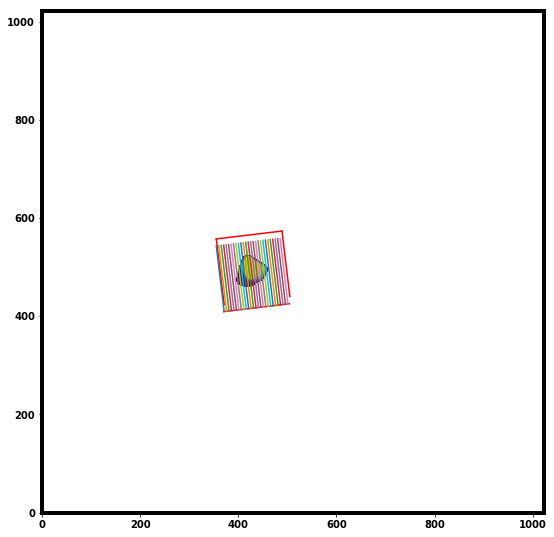

In [402]:
a,b,c=get_linescan_params(load_dm3(file_list[0]),plot=True)

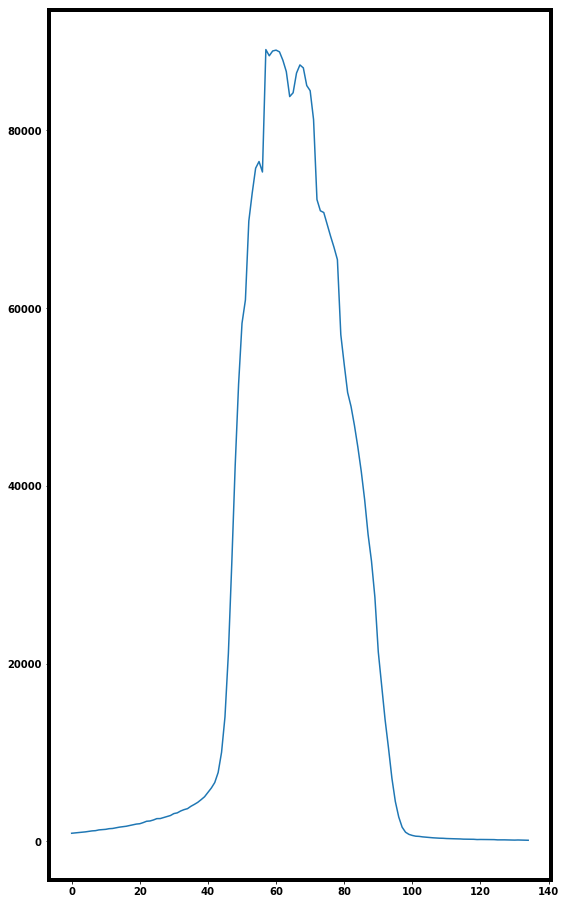

In [408]:
linescan(load_dm3(file_list[0]),plotline=True)

In [353]:
x,y,intercept=linescan(load_dm3(file_list[0]))

In [354]:
x

array([355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367,
       368, 369, 370, 371])

In [340]:
x1+300

array([400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412,
       413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425,
       426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438,
       439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449])

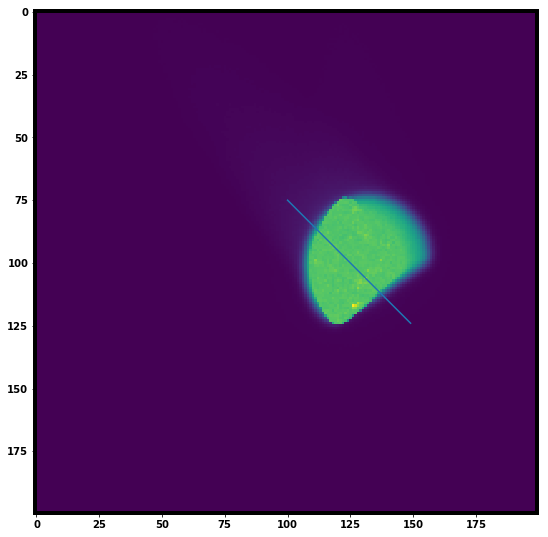

In [334]:
im=load_dm3(file_list[0])
plt.imshow(im[400:600,300:500])
x1=np.arange(100,150)
y1=np.arange(75,125)
plt.plot(x1,y1)


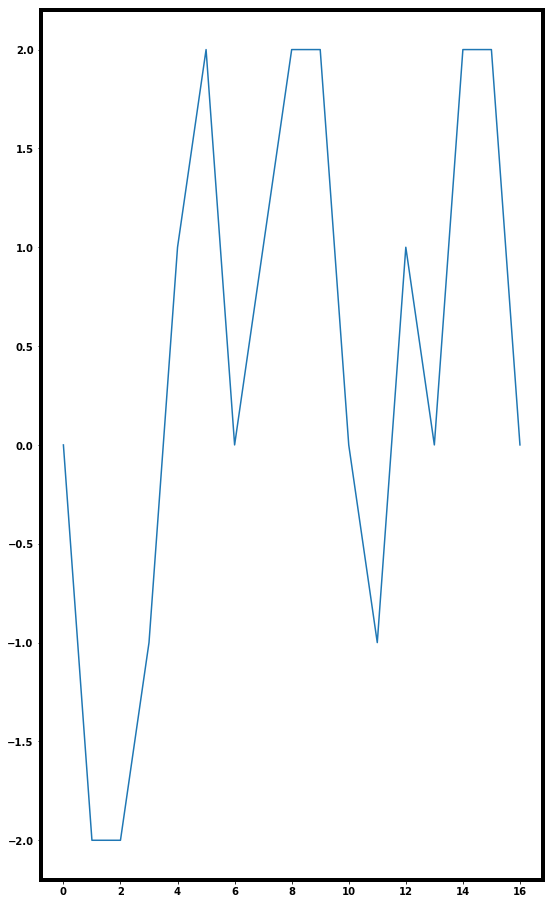

In [355]:
plt.plot(im[(y).astype(np.int),(x).astype(np.int)])

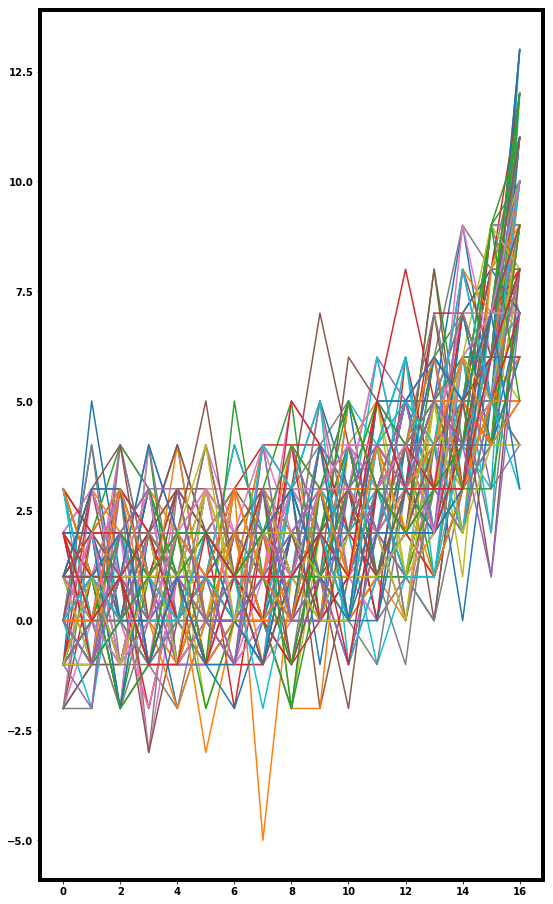

In [356]:

for l in range(len(intercept)):
    xit=x+l
    yit=y+intercept[l]
    plt.plot(im[yit.astype(np.int),xit.astype(np.int)])

In [278]:
x

array([355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367,
       368, 369, 370, 371])

In [279]:
y

array([133.70734927, 125.35063994, 116.99393061, 108.63722128,
       100.28051195,  91.92380262,  83.56709329,  75.21038396,
        66.85367463,  58.4969653 ,  50.14025598,  41.78354665,
        33.42683732,  25.07012799,  16.71341866,   8.35670933,
        -0.        ])

In [280]:
intercept

array([557.9269137 , 558.04657803, 558.16624235, 558.28590668,
       558.40557101, 558.52523533, 558.64489966, 558.76456399,
       558.88422832, 559.00389264, 559.12355697, 559.2432213 ,
       559.36288562, 559.48254995, 559.60221428, 559.72187861,
       559.84154293, 559.96120726, 560.08087159, 560.20053592,
       560.32020024, 560.43986457, 560.5595289 , 560.67919322,
       560.79885755, 560.91852188, 561.03818621, 561.15785053,
       561.27751486, 561.39717919, 561.51684352, 561.63650784,
       561.75617217, 561.8758365 , 561.99550082, 562.11516515,
       562.23482948, 562.35449381, 562.47415813, 562.59382246,
       562.71348679, 562.83315112, 562.95281544, 563.07247977,
       563.1921441 , 563.31180842, 563.43147275, 563.55113708,
       563.67080141, 563.79046573, 563.91013006, 564.02979439,
       564.14945872, 564.26912304, 564.38878737, 564.5084517 ,
       564.62811602, 564.74778035, 564.86744468, 564.98710901,
       565.10677333, 565.22643766, 565.34610199, 565.46

In [329]:
x,y,intercept=linescan(load_dm3(file_list[0]),plotline=True)

In [121]:
a

array([488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500,
       501, 502])

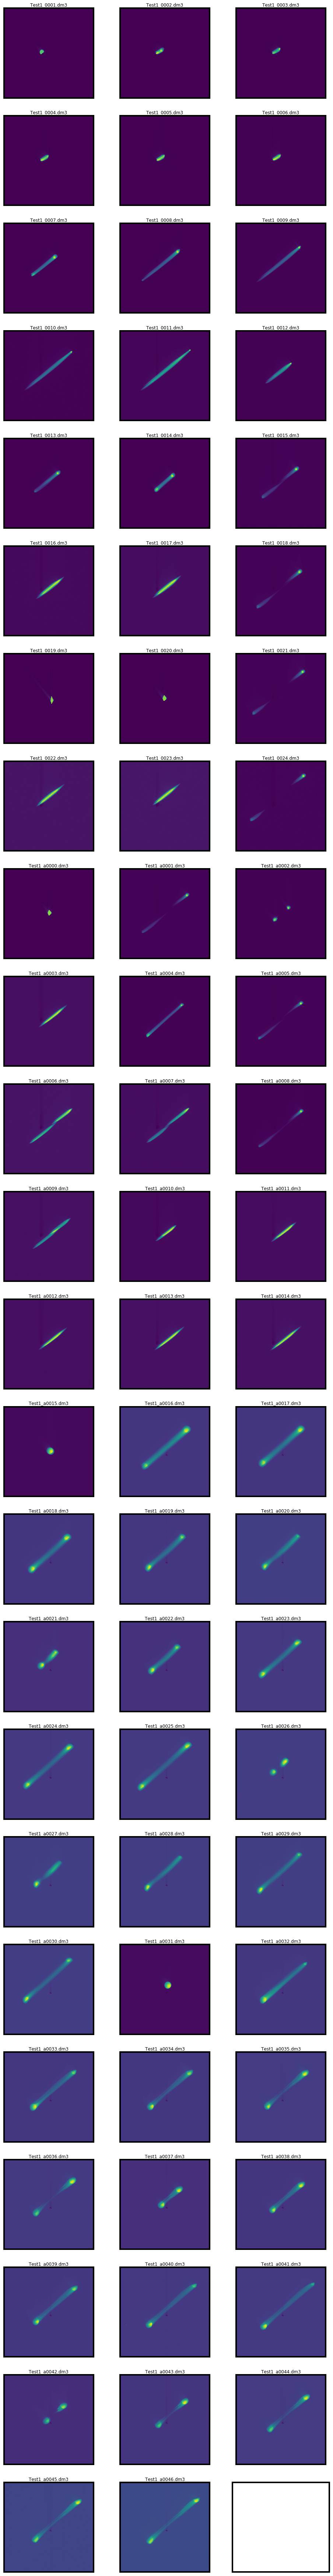

In [64]:
#-- Plot All...
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,n_rows*16/3)
fig, axs = plt.subplots(nrows=n_rows, ncols=3,
                        subplot_kw={'xticks': [], 'yticks': []})

for ax,k in zip(axs.flat,range(len(file_list))):
    z1=load_dm3(file_list[k])
    ax.imshow(z1)
    ax.set_title(file_list[k].split('\\')[1],fontsize=12)


0


IndexError: index -1 is out of bounds for axis 0 with size 0

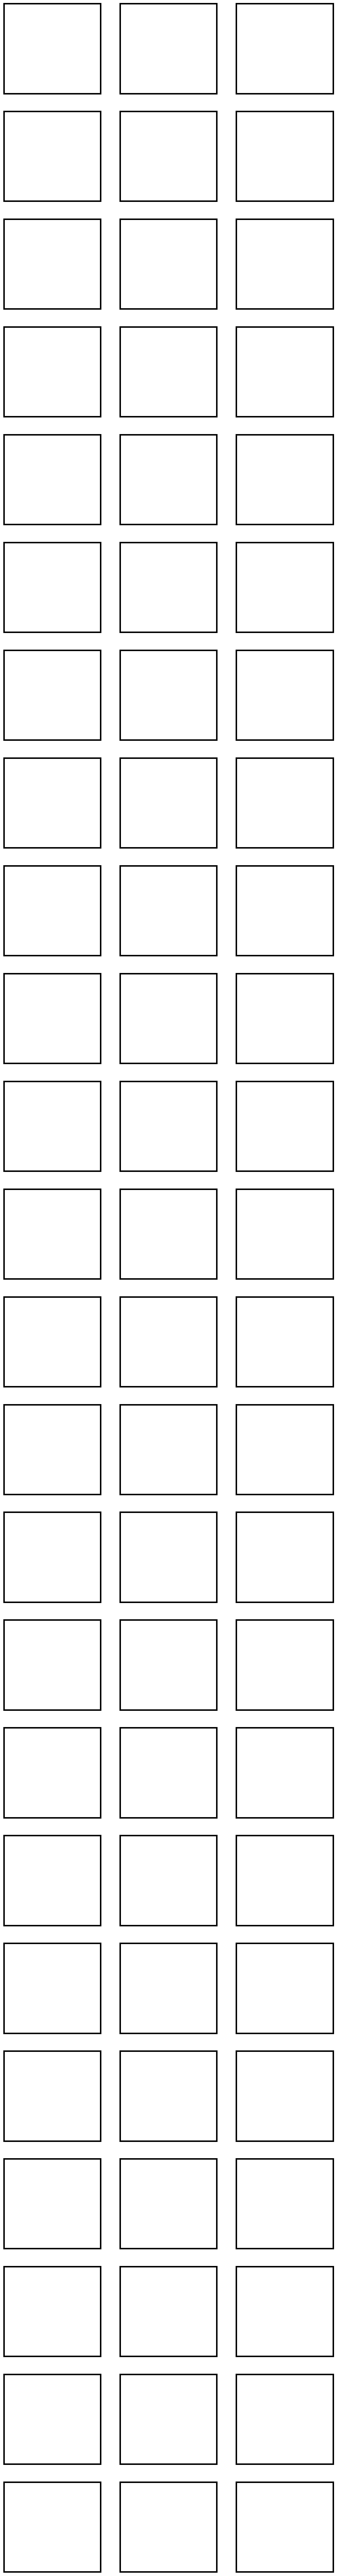

In [66]:
#-- Plot All linescans...
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,n_rows*16/3)
fig, axs = plt.subplots(nrows=n_rows, ncols=3,
                        subplot_kw={'xticks': [], 'yticks': []})

for ax,k in zip(axs.flat,range(len(file_list))):
    print(k)
    z1=load_dm3(file_list[k])
    ls=linescan(z1)
    ax.plot(ls)
    ax.set_title(file_list[k].split('\\')[1],fontsize=12)

850.0 150.0 850.0 150.0
856.5850460786852 156.5850460786852 843.4149539213148 143.4149539213148
863.1700921573704 163.17009215737036 836.8299078426296 136.82990784262964
869.7551382360556 169.75513823605553 830.2448617639444 130.24486176394447
876.3401843147408 176.34018431474072 823.6598156852592 123.65981568525928
882.9252303934259 182.92523039342592 817.0747696065741 117.0747696065741
889.5102764721111 189.5102764721111 810.4897235278889 110.48972352788891
896.0953225507963 196.09532255079628 803.9046774492037 103.90467744920372
902.6803686294814 202.68036862948145 797.3196313705186 97.31963137051855
909.2654147081666 209.26541470816665 790.7345852918334 90.73458529183335
915.8504607868518 215.8504607868518 784.1495392131482 84.14953921314819
922.435506865537 222.43550686553698 777.564493134463 77.564493134463
929.0205529442221 229.02055294422217 770.9794470557779 70.97944705577783
935.6055990229074 235.60559902290737 764.3944009770926 64.39440097709263
942.1906451015925 242.1906451

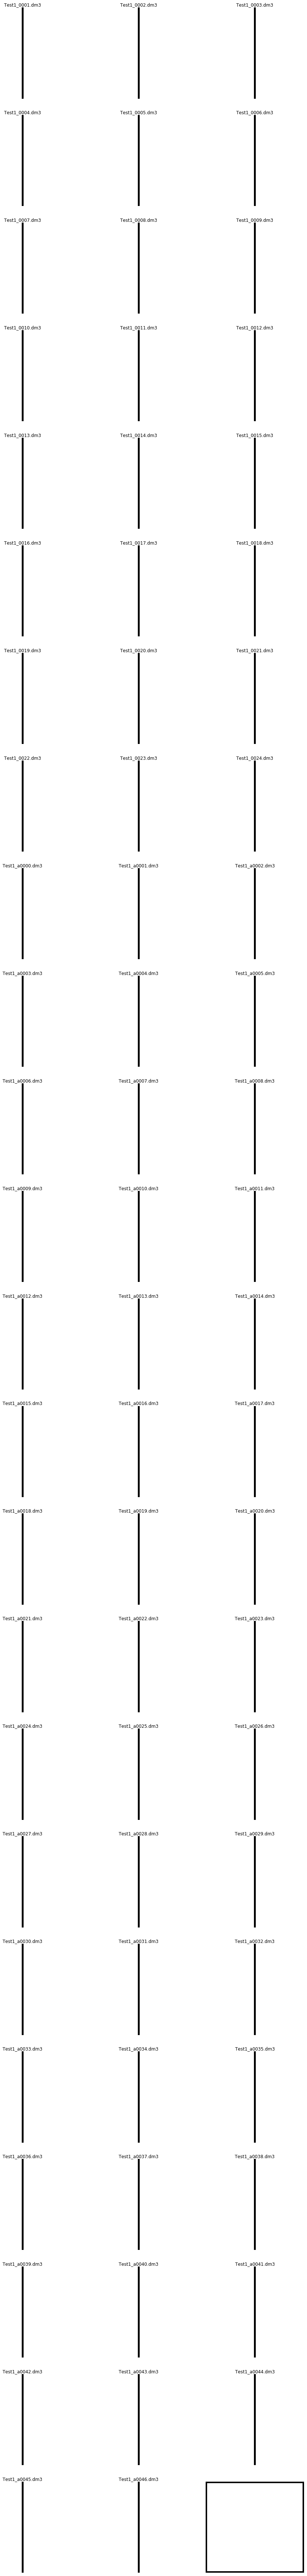

In [662]:
## Draw Line to get data
# Make a line with "num" points...
x0, y0 = 100, 850 # These are in _pixel_ coordinates!!
x1, y1 = 900, 150
num = 1000
mag=6000
l_length=((x1-x0)**2+(y1-y0)**2)**.5
d_perpix=24 #um
d_actual=l_length/(num)*d_perpix/mag
width=601 #odd number only
m=(y1-y0)/(x1-x0)
m_perp=-1/m
x=np.zeros((num,width))
y=np.zeros((num,width))
for n in np.arange(0,int(width/2+1),20):
    x0_edgep=x0+(n/2)/(1+m_perp**2)**.5
    x0_edgen=x0-(n/2)/(1+m_perp**2)**.5
    x1_edgep=x1+(n/2)/(1+m_perp**2)**.5
    x1_edgen=x1-(n/2)/(1+m_perp**2)**.5
    y0_edgep=y0+(n/2)/(1+m_perp**2)**.5
    y0_edgen=y0-(n/2)/(1+m_perp**2)**.5
    y1_edgep=y1+(n/2)/(1+m_perp**2)**.5
    y1_edgen=y1-(n/2)/(1+m_perp**2)**.5
    xp, yp = np.linspace(x0_edgep, x1_edgep, num), np.linspace(y0_edgep, y1_edgep, num)
    xn, yn = np.linspace(x0_edgen, x1_edgen, num), np.linspace(y0_edgen, y1_edgen, num)
    index=int(-n+width/2)
#     print(n,index)
    x[:,int(-n+width/2)]=xn
    x[:,int(n+width/2)]=xp
    y[:,int(-n+width/2)]=yn
    y[:,int(n+width/2)]=yp
#     print(y0_edgep,y1_edgep,y0_edgen,y1_edgen)
    
z=load_dm3(file_list[0:3])
#Extract the values along the line, using cubic interpolation

#-- Plot...
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,n_rows*16/3)
fig, axs = plt.subplots(nrows=n_rows, ncols=3,
                        subplot_kw={'xticks': [], 'yticks': []})
# axs.imshow(z)
alph=.1
# fig.subplots_adjust(left=0.03, right=0.97, hspace=0.01, wspace=0.01)
z_lave = np.zeros((num,len(file_list)))
for ax,k in zip(axs.flat,range(len(file_list))):
    z1=z[k]
    ax.imshow(z1)
    ax.set_title(file_list[k].split('\\')[1],fontsize=12)
    z_lines=np.zeros(x.shape)
    z_lines_reduced=[]
    for l in range(width):
        zi = z[x[:,l].astype(np.int), y[:,l].astype(np.int)]
        ax.plot([x0, x1], [y0, y1], 'ro-')
        ax.plot([x[0,l], x[-1,l]], [y[0,l], y[-1,l]], 'ko-',alpha=alph)
        z_lines[:,l]=zi
        if np.sum(z_lines[:,l],axis=0)>0: # remove excess lines from average response
            z_lines_reduced.append(z_lines[:,l])
    z_lines_reduced=np.asarray(z_lines_reduced)    
    z_lave[:,k]=np.mean(z_lines_reduced, axis=0)
        
#     ax2.plot(zi)
plt.tight_layout()
plt.show()

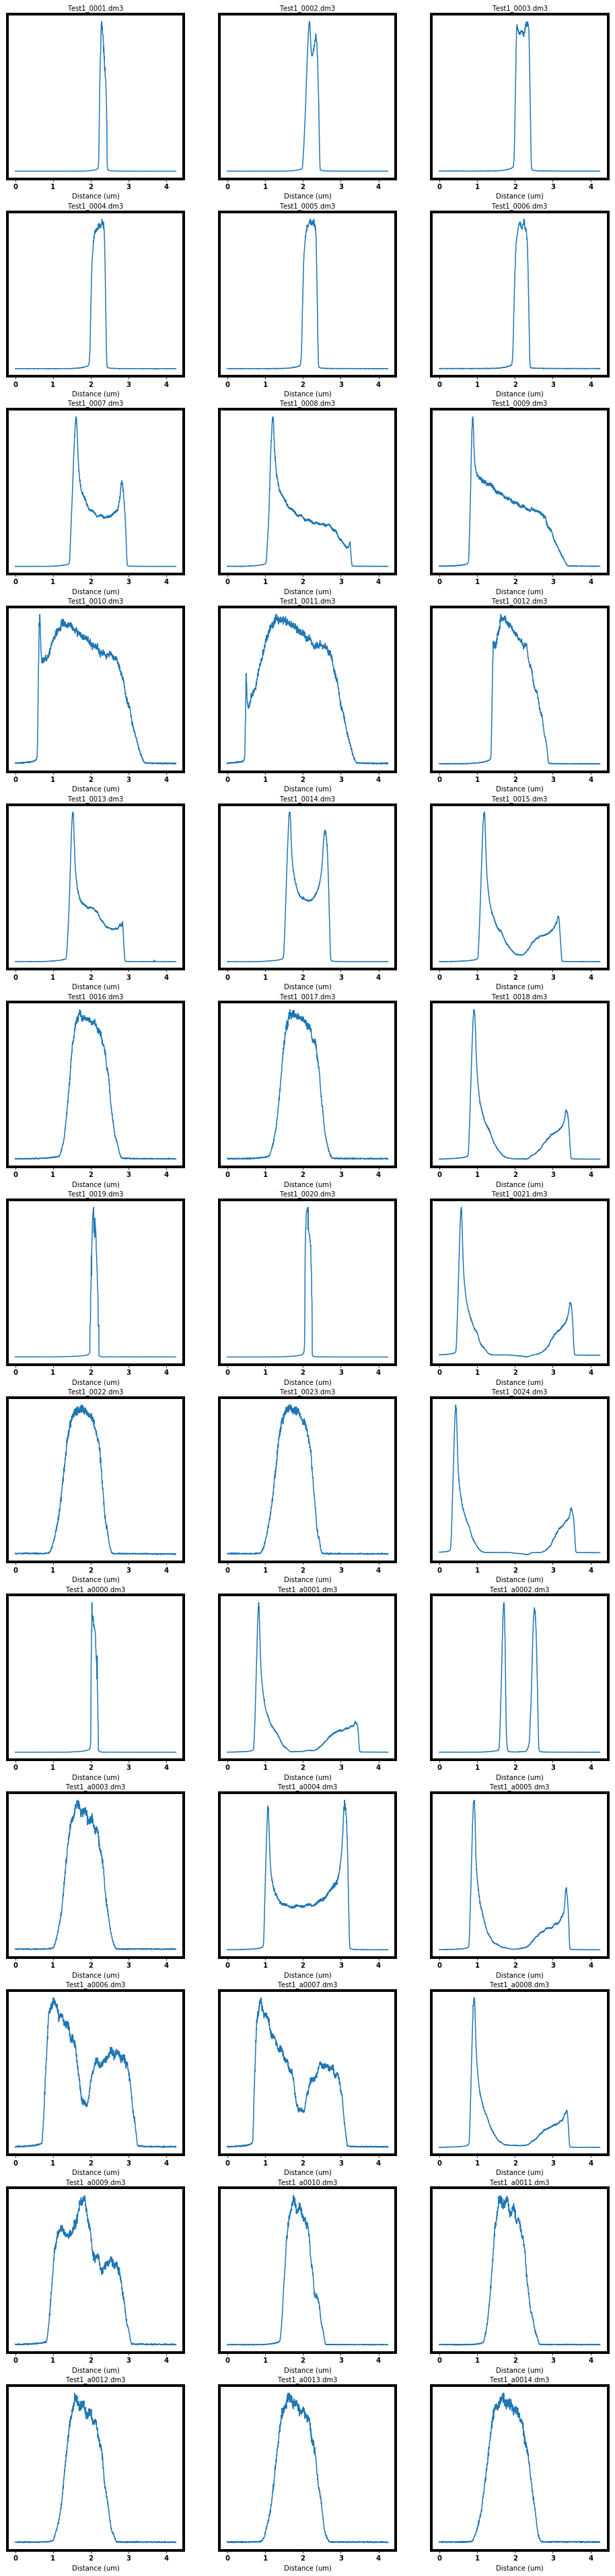

In [483]:
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,n_rows*16/3)
X= np.arange(0,num)*d_actual
fig, axs = plt.subplots(nrows=n_rows, ncols=3,
                        subplot_kw={ 'yticks': []})
for ax,k in zip(axs.flat,range(len(file_list))):
    ax.plot(X,z_lave[:,k])
    ax.set_title(file_list[k].split('\\')[1],fontsize=10)
    ax.set_xlabel('Distance (um)')

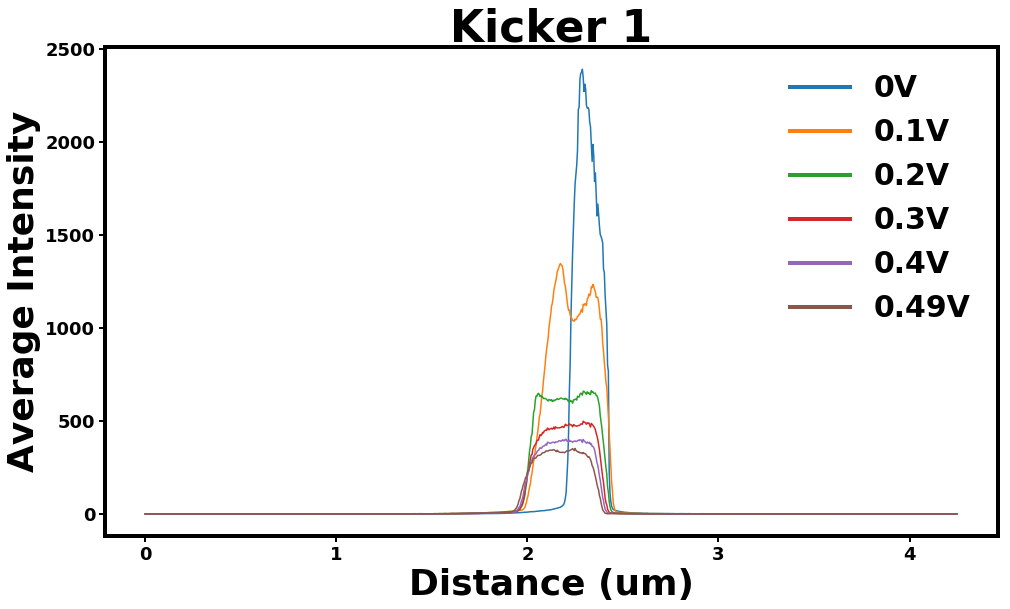

In [484]:
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,9)

Labels=['0V','0.1V','0.2V','0.3V','0.4V','0.49V']
fig, ax1 = plt.subplots()
plt.title('Kicker 1', fontsize=44, fontweight='bold')
ax1.set_xlabel('Distance (um)', fontsize=36, fontweight='bold')
ax1.set_ylabel('Average Intensity', fontsize=36, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax1.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)

for k in range(6):
    ax1.plot(X,z_lave[:,k],label=Labels[k])

leg=plt.legend(fontsize=30, loc='best', frameon=False)

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

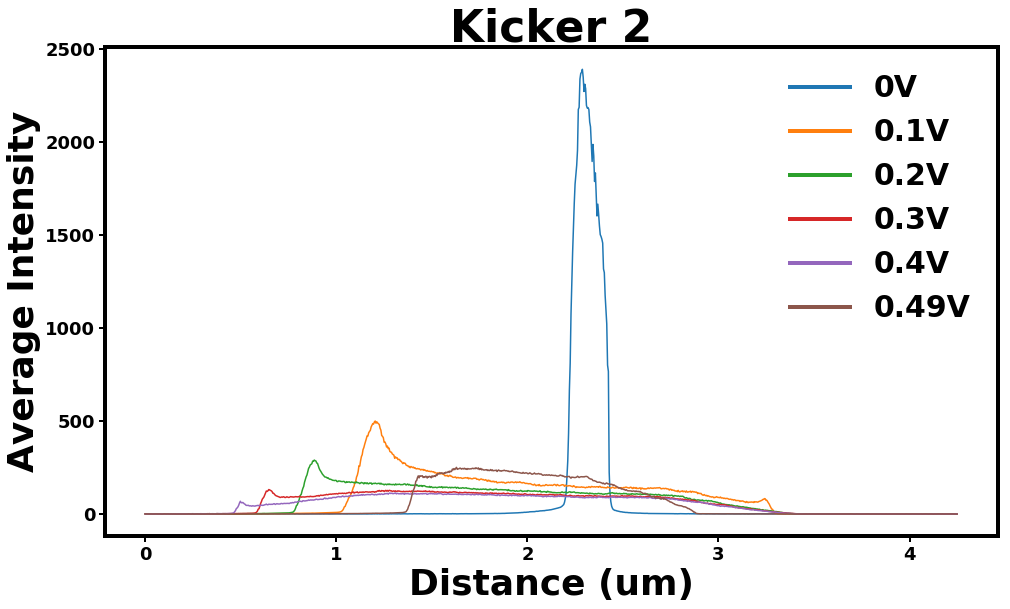

In [485]:
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,9)

Labels=['0V','0.1V','0.2V','0.3V','0.4V','0.49V']
fig, ax1 = plt.subplots()
plt.title('Kicker 2', fontsize=44, fontweight='bold')
ax1.set_xlabel('Distance (um)', fontsize=36, fontweight='bold')
ax1.set_ylabel('Average Intensity', fontsize=36, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax1.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
data_select=[0,7,8,9,10,11]
for a,k in enumerate(data_select):
    ax1.plot(X,z_lave[:,k],label=Labels[a])

leg=plt.legend(fontsize=30, loc='best', frameon=False)

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

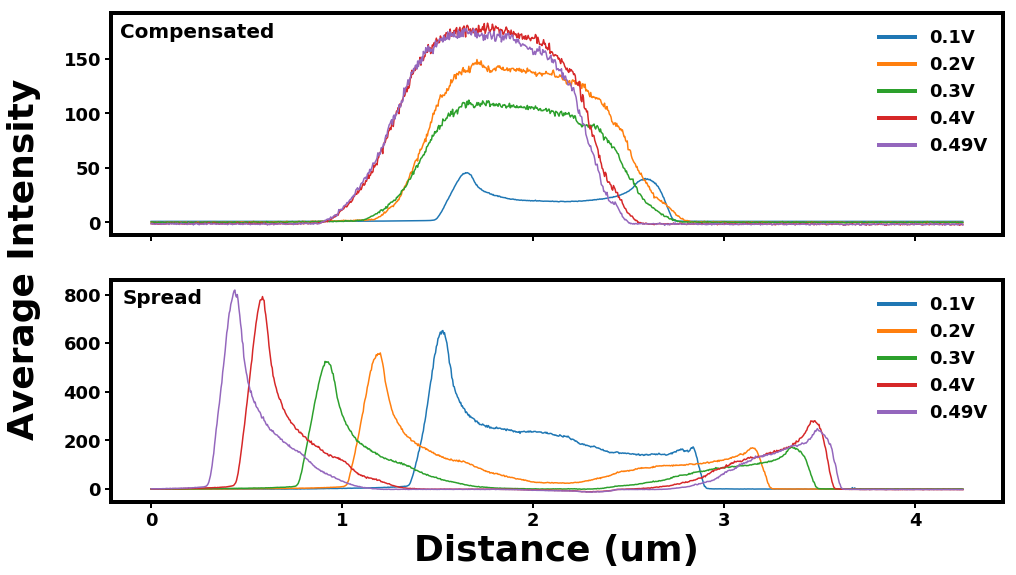

In [486]:
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,9)

# Labels=['0.1V','0.2V','0.3V','0.4V','0.49V']
Labels=['0.1V','0.1V','0.2V','0.2V','0.3V','0.3V','0.4V','0.4V','0.49V','0.49V']
# Labels=['13','14','15','16','18','17','21','22','24','23']
fig, (ax1,ax2) = plt.subplots(2, sharex=True)
# plt.title('Both Kickers', fontsize=44, fontweight='bold')
ax2.set_xlabel('Distance (um)', fontsize=36, fontweight='bold')
fig.text(0.05, 0.5,'Average Intensity', ha='center', va='center', rotation='vertical', fontsize=36, fontweight='bold')
fig.text(0.2, 0.85,'Compensated', ha='center', va='center', fontsize=20, fontweight='bold')
fig.text(0.17, 0.44,'Spread', ha='center', va='center', fontsize=20, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax1.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)

ax2.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax2.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
data_select=[13,14,15,16,18,17,21,22,24,23]
b=0
c=0
for a,k in enumerate(data_select):
    if a%2:
        ax1.plot(X,z_lave[:,k-1],label=Labels[a])
        b+=1
    else:
        ax2.plot(X,z_lave[:,k-1],label=Labels[a])
        c+=1
leg1=ax1.legend(fontsize=18, loc='best', frameon=False)
leg2=ax2.legend(fontsize=18, loc='best', frameon=False)
for legobj in leg1.legendHandles:
    legobj.set_linewidth(4.0)
    
for legobj in leg2.legendHandles:
    legobj.set_linewidth(4.0)

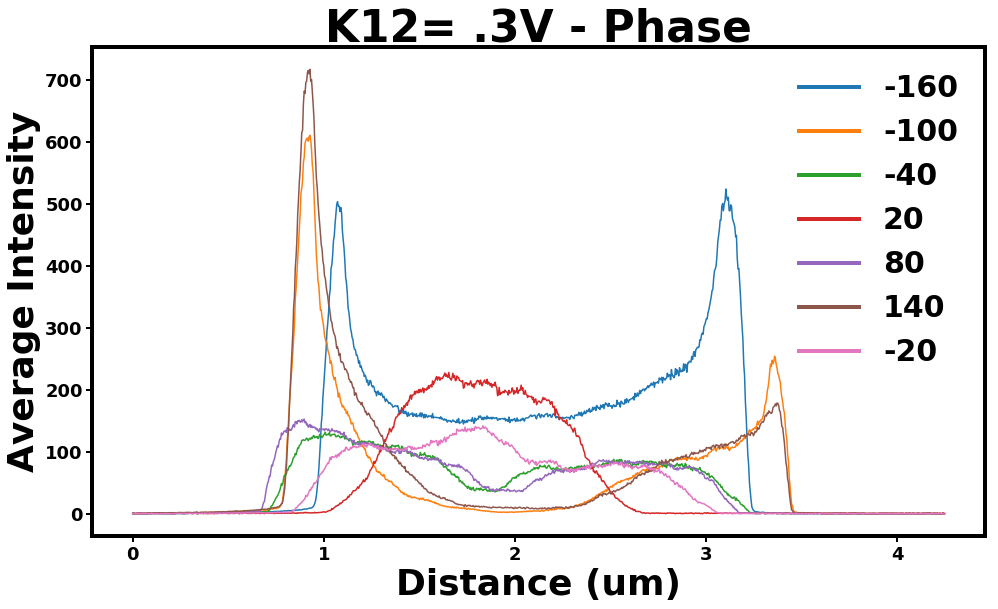

In [487]:
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,9)

Labels=['-160','-100','-40','20','80','140','-20']
fig, ax1 = plt.subplots()
plt.title('K12= .3V - Phase', fontsize=44, fontweight='bold')
ax1.set_xlabel('Distance (um)', fontsize=36, fontweight='bold')
ax1.set_ylabel('Average Intensity', fontsize=36, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax1.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
data_select=[28,29,30,27,31,32,33]
for a,k in enumerate(data_select):
    ax1.plot(X,z_lave[:,k]-min(z_lave[:,k]), label=Labels[a])

leg=plt.legend(fontsize=30, loc='best', frameon=False)

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

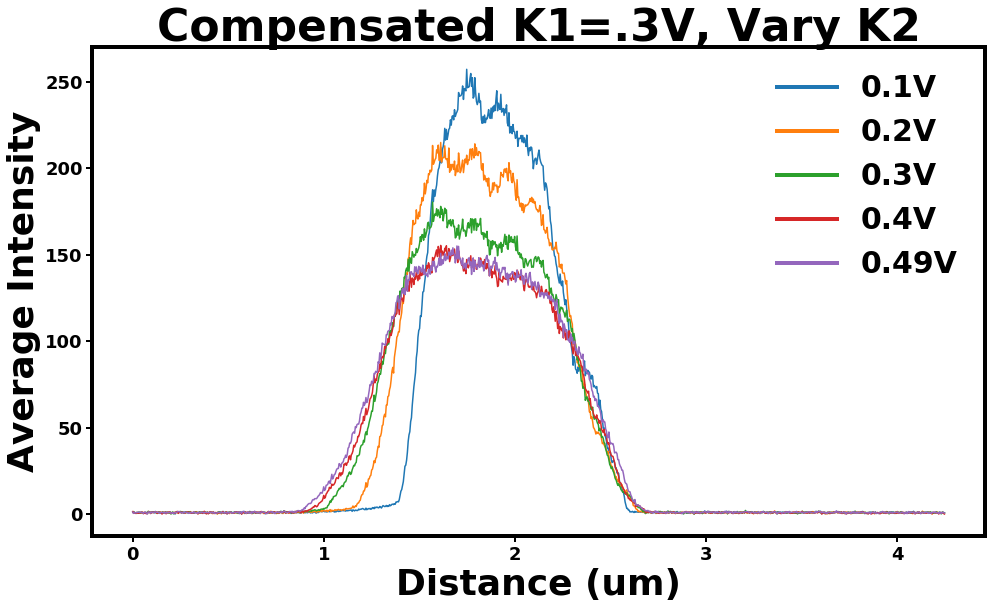

In [489]:
'''Sets up plot parameters and generates plot'''
plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=4
n_rows=int(np.ceil(len(file_list)/3))
plt.rcParams['figure.figsize'] = (16,9)

Labels=['0.1V','0.2V','0.3V','0.4V','0.49V']
fig, ax1 = plt.subplots()
plt.title('Compensated K1=.3V, Vary K2', fontsize=44, fontweight='bold')
ax1.set_xlabel('Distance (um)', fontsize=36, fontweight='bold')
ax1.set_ylabel('Average Intensity', fontsize=36, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=18, width=2, length=6)
ax1.tick_params(axis='both', which='minor', labelsize=18, width=2, length=6)
data_select=[34,35,36,37,38]
for a,k in enumerate(data_select):
    ax1.plot(X,z_lave[:,k]-min(z_lave[:,k]), label=Labels[a])

leg=plt.legend(fontsize=30, loc='best', frameon=False)

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

In [472]:
z_lines_reduced=[]
for x in range(z_lines.shape[1]):
    if np.sum(z_lines[:,x],axis=0)>0:
        z_lines_reduced.append(z_lines[:,x])
z_lines_reduced=np.asarray(z_lines_reduced)        
    

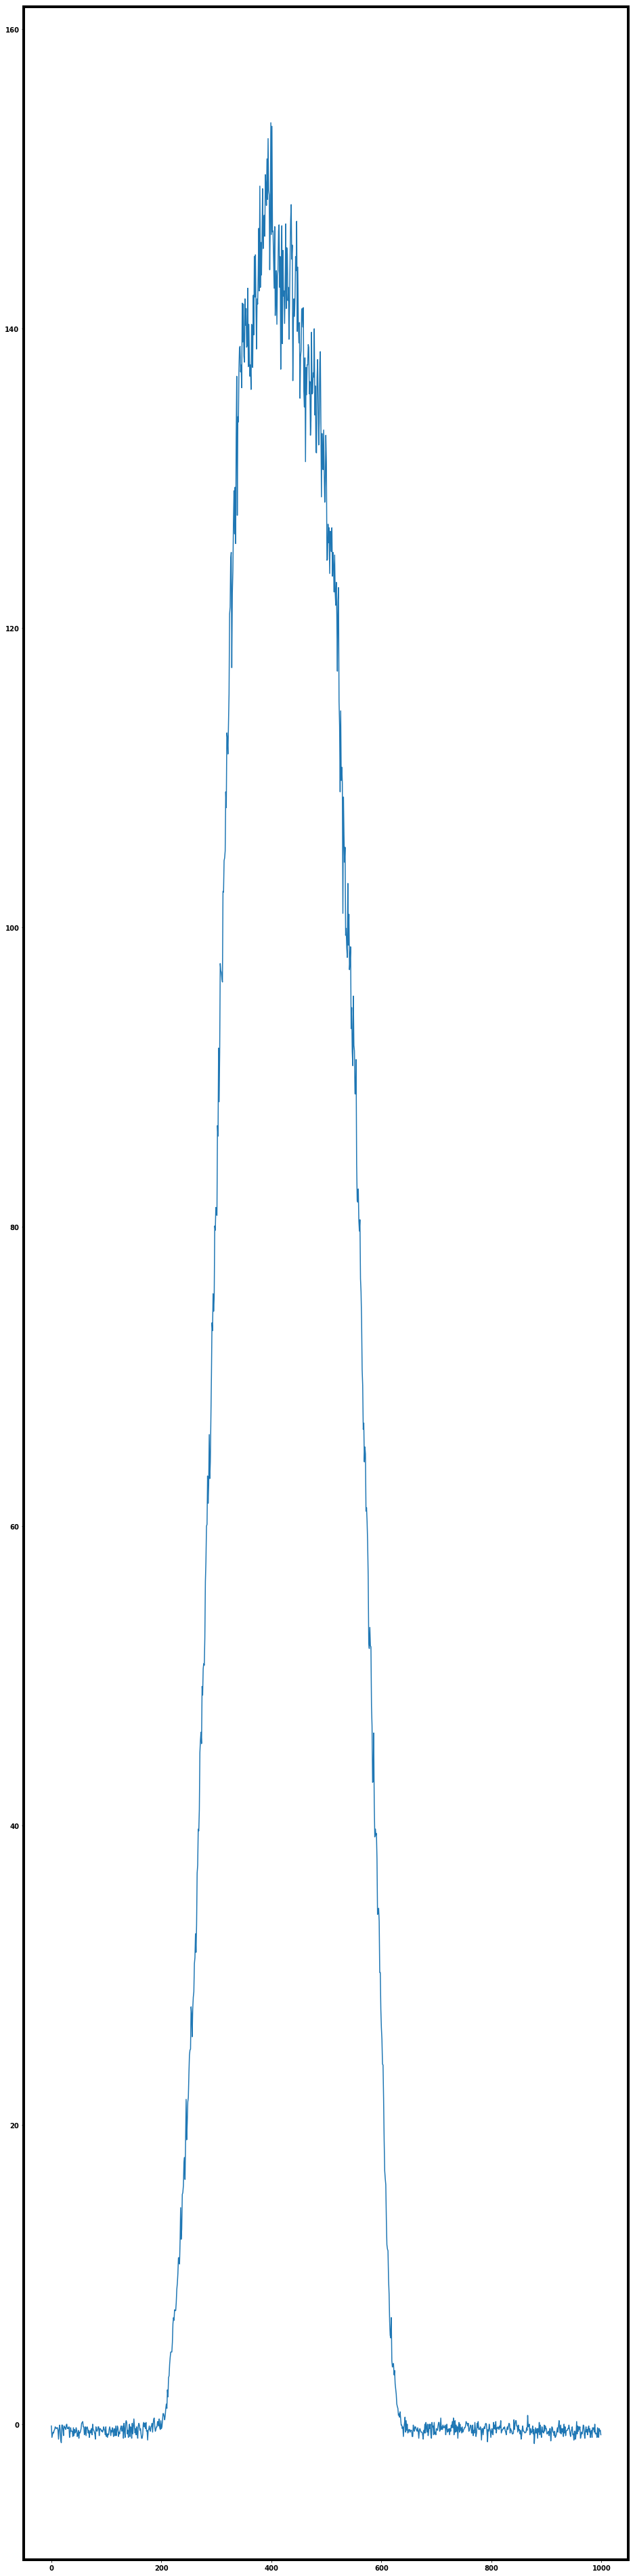

In [480]:
fig, ax = plt.subplots()
ax.plot(np.mean(z_lines_reduced,axis=0))

In [8]:
meta_stack[:,:,0]

array([['Acquisition-Device-Active-Size-(pixels)', (1024, 1024)],
       ['Acquisition-Device-Camera-Number', 0],
       ['Acquisition-Device-CCD-Pixel-Size-(um)', (24.0, 24.0)],
       ['Acquisition-Device-Configuration-Transpose-Diagonal-Flip',
        False],
       ['Acquisition-Device-Configuration-Transpose-Horizontal-Flip',
        True],
       ['Acquisition-Device-Configuration-Transpose-Vertical-Flip', True],
       ['Acquisition-Device-Name', ' MSC'],
       ['Acquisition-Device-Source', ' MSC'],
       ['Acquisition-Frame-Area-Transform-Class-Name',
        'cm_acquisitiontransform_list'],
       ['Acquisition-Frame-Area-Transform-Transform-List-Binning',
        (1, 1)],
       ['Acquisition-Frame-Area-Transform-Transform-List-Class-Name',
        'cm_acquisitiontransform'],
       ['Acquisition-Frame-Area-Transform-Transform-List-Sub-Area-Adjust',
        (0, 0, 0, 0)],
       ['Acquisition-Frame-Area-Transform-Transform-List-Transpose-Diagonal-Flip',
        False],
    

In [584]:
def diff_mat(matrix):
    
    if matrix.ndim !=2:
        raise ValueError("input not 2 dim (n x m)")
    
    nsize=matrix.shape[0]
    msize=matrix.shape[1]
    diffy=[]
    diffx=[]
    for y in range(nsize):
        row_diff = matrix[y,:]-matrix[y-1,:]
        diffy.append(row_diff)
    for x in range(msize):
        col_diff = matrix[:,x]-matrix[:,x-1]
        diffx.append(col_diff)
    diffy = np.array(diffy)
    diffx = np.transpose(np.array(diffx)) 
    
    return diffy, diffx

In [585]:
%timeit remove_outliers(im)

12.7 s ± 2.48 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [583]:
%timeit remove_outliers(im)

18.5 s ± 785 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [576]:
def diff_mat(matrix, copy=False):
    if copy ==True:
        mat=matrix.copy()
    if matrix.ndim !=2:
        raise ValueError("input not 2 dim (n x m)")
    mat=matrix
    A=np.expand_dims(mat[0,:],axis=0)
    mat0=np.concatenate((mat,A),axis=0)
    
    B=np.expand_dims(mat[:,0],axis=1)
    mat1 = np.concatenate((mat,B),axis=1)
    
    diffy = np.diff(mat0,axis=0)
    diffx = np.diff(mat1,axis=1)
    
    return diffy, diffx

In [577]:
a,b=diff_mat(im)
print(a.shape,b.shape,im.shape)

(1024, 1024) (1024, 1024) (1024, 1024)


In [581]:
A=np.array([[1,8,6],[7,100,3],[4,2,9]])
a,b=diff_mat(A)
# print(a.shape,b.shape)
print(A,b)

[[  1   8   6]
 [  7 100   3]
 [  4   2   9]] [[  7  -2  -5]
 [ 93 -97   4]
 [ -2   7  -5]]


In [563]:
A=np.array([[1,8,6],[7,5,3],[4,2,9]])
Av=np.expand_dims(A[:,0],axis=1)
np.concatenate((A,Av),axis=1)

array([[1, 8, 6, 1],
       [7, 5, 3, 7],
       [4, 2, 9, 4]])

In [568]:
A=im
Av=np.expand_dims(im[:,0],axis=1)
np.concatenate((im,Av),axis=1)

array([[0.15215622, 0.15215622, 0.15174939, ..., 0.15174939, 0.15174939,
        0.15215622],
       [0.15093572, 0.15174939, 0.15215622, ..., 0.15215622, 0.15174939,
        0.15093572],
       [0.15215622, 0.15052889, 0.15174939, ..., 0.15093572, 0.15093572,
        0.15215622],
       ...,
       [0.15134255, 0.15174939, 0.15174939, ..., 0.15174939, 0.15256306,
        0.15134255],
       [0.15174939, 0.15134255, 0.15215622, ..., 0.15256306, 0.15174939,
        0.15174939],
       [0.15215622, 0.15174939, 0.15256306, ..., 0.15296989, 0.15256306,
        0.15215622]])

In [555]:
np.__version__

'1.15.4'